# 10章 ディープラーニングによる時系列解析


## 本章の構成

- 前書き
  - 深層学習による時系列解析の概要(利点、気をつけるポイント)
  - 前処理は原理的には不要だが、現実的には必要
  - 柔軟性が高いので、まだまだ将来の展望がある
- ディープラーニングの概念
  - 行列計算の連鎖
- ニューラルネットワークのプログラミング方
  - グラフ
  - フレームワークを使う
- 訓練用パイプラインの構築
  - ここから実例（電力使用量の変化量予測）に基づいた解説
  - まずは、実際にモデルを構築する前に、データの前処理、評価指標の定義を実装する
- フィードフォワードネットワーク
  - ここから４節にわたって、具体的に時系列を分析するモデルを定義する
  - 一つ目は単純なfull-connectネットワーク
  - 単純だがデータがある程度あればFCネットワークで性能が出る
- CNN
  - CNNでの時系列解析
  - 時系列の時間的な幅と計測ポイントについて二次元のデータとして扱う（幅(計測ポイント)は1とする）
- RNN
  - GRUの実装
- アーキテクチャの組み合わせ
  - ARモデルの組み合わせ
  - かなり精度が高い

In [1]:
import os
import sys
import numpy as np
import pandas as pd
from scipy import stats

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale = 1.5)
c_list = sns.color_palette().as_hex()
color_num = len(c_list)

## 準備

mxnetをインストールする。

[公式ドキュメントを参考](https://mxnet.apache.org/versions/1.9.0/get_started?)に実装環境に合わせた方法でインストールする。

ここでは、mxnet v1.9.0 をMacOSのCPU環境でインストールする。

In [2]:
#! pip install mxnet

インストールできたかの確認

In [3]:
import mxnet as mx
a = mx.nd.ones((2, 3))
b = a * 2 + 1
b.asnumpy()

array([[3., 3., 3.],
       [3., 3., 3.]], dtype=float32)

mxnetの基本の構文（モデルとOptimizerの定義まで）。

他のフレームワークと比べて特別平易でも複雑でもない。

In [4]:
# モデルの定義
net = mx.gluon.nn.Sequential()
net.add(
    mx.gluon.nn.Dense(120, activation='relu'), # input > 120次元のfull-connect
    mx.gluon.nn.Dense(1)                       # １２０次元 > 1次元のfull-connect
)
net.initialize(init=mx.init.Xavier()) # 初期化(下記参照)

# 損失関数の定義
L2Loss = mx.gluon.loss.L2Loss() # 二乗誤差。タスクに依存する。これはモデルの定義に含まれると考えるべき。

# Trainerの定義
trainer = mx.gluon.Trainer(
    net.collect_params(), 
    'sgd', 
    {'learning_rate':0.1}, 
)

初期化にはXavierの初期化と呼ばれる初期化方法を使っている。
これは、入力と出力の分散が確保できるような初期化法とのこと。元々はシグモイド活性化関数の学習過程の解析に基づいて開発された。以下の参考文献参照。

- [Xavier and Bengio, 2010](https://proceedings.mlr.press/v9/glorot10a.html)

ReLU向けに開発されたHe初期化と呼ばれる手法もある。

mxnetの実装がXavier初期化だけなのかは確認してない。ドキュメントには`Xavier or similar initialization scheme.`とあるので、活性化関数によって自動で変えてたりする？？

## データの確認と問題設定

### データの確認

In [5]:
# サンプルデータの取得
# ! wget https://github.com/PracticalTimeSeriesAnalysis/BookRepo/raw/master/Ch10/electricity.txt.gz
# ! gzip -d electricity.txt.gz

In [6]:
elec = pd.read_csv('electricity.txt', header=None)
elec.shape

(26304, 321)

In [7]:
elec.head()

,0,1,2,3,4,5,6,7,8,9,...,311,312,313,314,315,316,317,318,319,320
0,14.0,69.0,234.0,415.0,215.0,1056.0,29.0,840.0,226.0,265.0,...,676.0,372.0,80100.0,4719.0,5002.0,48.0,38.0,1558.0,182.0,2162.0
1,18.0,92.0,312.0,556.0,292.0,1363.0,29.0,1102.0,271.0,340.0,...,805.0,452.0,95200.0,4643.0,6617.0,65.0,47.0,2177.0,253.0,2835.0
2,21.0,96.0,312.0,560.0,272.0,1240.0,29.0,1025.0,270.0,300.0,...,817.0,430.0,96600.0,4285.0,6571.0,64.0,43.0,2193.0,218.0,2764.0
3,20.0,92.0,312.0,443.0,213.0,845.0,24.0,833.0,179.0,211.0,...,801.0,291.0,94500.0,4222.0,6365.0,65.0,39.0,1315.0,195.0,2735.0
4,22.0,91.0,312.0,346.0,190.0,647.0,16.0,733.0,186.0,179.0,...,807.0,279.0,91300.0,4116.0,6298.0,75.0,40.0,1378.0,191.0,2721.0


321地点の１時間毎の電力消費量データ。

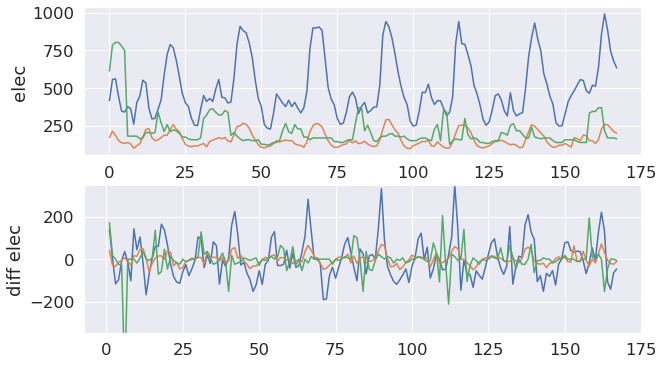

In [8]:
ps = [3, 13, 113]

fig = plt.figure(figsize=(10, 3*2))
ax = fig.subplots(2, 1)

for i, pos in enumerate(ps):
    ax[0].plot(elec[pos][0:24*7], color=c_list[i]);
    ax[1].plot(elec.diff()[pos][1:24*7], color=c_list[i]);
ax[1].set_ylim(-350, 350);
ax[0].set_ylabel("elec");
ax[1].set_ylabel("diff elec");

### 問題設定

- このデータに対して、３期先（３時間後）の電力消費量の差分を予測する。
- 評価指標は予測値と目標値の相関
- データは、時間的に古い順に、訓練、評価、テストに分割する

実際の問題の場合には、この時点で地点間のそうかんの有無やトレンド成分などについての分析をしておくべき。
だがここでは、とにかくモデリング作業に入る。

学習プロセスを進めるにあたって、本書では大きく二つのパートに分けている。

- 訓練用パイプラインの構築（10.3）
  - データの整形、イテレータ構築、評価指標定義、全体の処理の統合（パイプライン構築）
- 深層学習モデルの紹介、定義、学習、評価（10.4~10.10.7）
  - full-connect, CNN, RNN, 従来モデルとの組み合わせ

## 訓練用パイプラインの構築

ここでは、上記の問題設定に対して予測モデルを構築していく作業に入るわけだが、最初は学習パイプラインを構築する。
データの処理やモデルの外部出力、評価指標の定義を行う。

notebook上では、上から順次流れていくため、構成要素全体を処理する部分は後で書くことにする。

### パラメータ定義

パラメータを設定する。書籍ではコマンドライン引数になっていたが、ここでは固定パラメータとしてここで設定する。

In [9]:
DATA_SEGMENTS    = { 'tr': 0.6, 'va': 0.2, 'tst': 0.2} # 訓練、評価、テストのデータ割合の設定
THRESHOLD_EPOCHS = 2            # 
COR_THRESHOLD    =  0.005       # 

WIN              = 24 ##* 7     # スライス窓幅（単位は時間）
H                = 3            # horizon, 予測するステップ数

# model details 
#MODEL            = 'rnn_model'  # 利用するモデル
## CNNのパラメータ
SZ_FILT          = 8            # CNNのカーネルサイズ
N_FILT           = 10           # フィルタ数
## RNNのパラメータ
RNN_UNITS        = 10           # 
SEASONAL_PERIOD  = 24           # 

# training details
BATCH_N          = 1024         # バッチサイズ
LR               = 0.0001       # 学習率
DROP             = 0.2          # Drop-out rate
N_EPOCHS         = 30           # 学習Epoch数

# data details
DATA_FILE        = 'electricity.txt'
SAVE_DIR         = "out"

### 入力データの準備

In [10]:
def diff_elec(data_file, periods=1):
    """データの前処理として、差分データを作成する
    書籍では、diffをとった後の謎のCSVファイルが使われているが、そんなものないのでここで作る。
    
    Args:
        data_file [string]: データファイルパス
        periods [int, optional]: 差分を取る範囲, default=1
    Returns:
        [pandas.DataFrame]: 
    """
    df = pd.read_csv(data_file, sep=',', header=None)
    ddf = df.diff(periods=periods)
    return ddf.loc[periods:].reset_index(drop=True)

In [11]:
def prepared_data(data_file, win, h, model_name):
    """データを読み込み、以下の前処理を行う
    - 正規化（データ全体を使って平均0,標準偏差1）
    - データの整形
      - 学習用にデータの形式を変える
      - ターゲットデータの作成
    """
    df = diff_elec(data_file=data_file)
    x  = df.iloc[:, :].values
    x = (x - np.mean(x, axis = 0)) / (np.std(x, axis = 0)) ## 正規化(*1)
    
    if model_name == 'fc_model':
        # NC形式でのデータ
        X = np.hstack([x[1:-h], x[0:-(h+1)]])
        Y = x[(h+1):]
        return (X, Y)
    else:
        # NTCデータ形式
        ## X shape = num examples * time win * num channels (NTC)
        X = np.zeros((x.shape[0] - win - h, win, x.shape[1]))
        ## Y shape = num examples * num channels
        Y = np.zeros((x.shape[0] - win - h, x.shape[1]))
        ## 以下、各時間でwin幅分抜き出して入力データxとしている
        for i in range(win, x.shape[0] - h):
            y_i = x[i + h - 1     , :] # 目標の値はhステップ先の値
            x_i = x[(i - win) : i , :] # 入力データは直前のwinステップ
            X[i-win] = x_i
            Y[i-win] = y_i
        return (X, Y)

def prepare_iters(data_file, win, h, model, batch_n):
    """イテレータ
    訓練データ、評価データ、テストデータについてのイテレータを生成する
    """
    X, Y = prepared_data(data_file, win, h, model)

    n_tr = int(Y.shape[0] * DATA_SEGMENTS['tr'])
    n_va = int(Y.shape[0] * DATA_SEGMENTS['va'])

    X_tr, X_valid, X_test = X[ : n_tr], X[n_tr : n_tr + n_va], X[n_tr + n_va : ]
    Y_tr, Y_valid, Y_test = Y[ : n_tr], Y[n_tr : n_tr + n_va], Y[n_tr + n_va : ]
    
    iter_tr = mx.io.NDArrayIter(data = X_tr,
                                label = Y_tr,
                                batch_size = batch_n)
    iter_val = mx.io.NDArrayIter(data = X_valid,
                                 label = Y_valid,
                                 batch_size = batch_n)
    iter_test = mx.io.NDArrayIter(data = X_test,
                                  label = Y_test,
                                  batch_size = batch_n)
    return (iter_tr, iter_val, iter_test)

- *1: データの正規化。全データを使ってz-score化している
  - 本来は、先読みを防ぐために学習データで正規化パラメータを作成するなどする必要がある

#### 入力データの整形についての確認(NC形式)

入力データXは、現時刻tと１ステップ前t-1となっている。
Y(目的変数)は、Hステップ先を予測するので、xのt+Hが目的変数になる。

ところで、なんで入力データは１期ステップ前だけなのだろう??winを設定しているのだからwin期使うのではないの？？

In [12]:
X, Y = prepared_data(data_file=DATA_FILE, win=WIN, h=H, model_name='fc_model')
display(X.shape)
display(Y.shape)

(26299, 642)

(26299, 321)

In [13]:
tmp = diff_elec(data_file=DATA_FILE)
x_tmp = tmp.iloc[:, :].values
x_tmp = (x_tmp - np.mean(x_tmp, axis = 0)) / (np.std(x_tmp, axis = 0))
x_tmp.shape

(26303, 321)

In [14]:
display(X[0, 1:10])
display(x_tmp[1, 1:10])

array([ 3.06347754e-01,  3.70997705e-04,  5.52456171e-02, -7.06265147e-01,
       -1.04713646e+00, -1.46982988e-04, -6.34592074e-01, -1.94949195e-02,
       -7.50626884e-01])

array([ 3.06347754e-01,  3.70997705e-04,  5.52456171e-02, -7.06265147e-01,
       -1.04713646e+00, -1.46982988e-04, -6.34592074e-01, -1.94949195e-02,
       -7.50626884e-01])

In [15]:
display(X[0, 321+1:321+10])
display(x_tmp[0, 1:10])

array([ 1.76176242e+00,  3.36829801e+00,  1.95160764e+00,  2.71832661e+00,
        2.61338311e+00, -1.46982988e-04,  2.15903375e+00,  8.76079684e-01,
        1.40736593e+00])

array([ 1.76176242e+00,  3.36829801e+00,  1.95160764e+00,  2.71832661e+00,
        2.61338311e+00, -1.46982988e-04,  2.15903375e+00,  8.76079684e-01,
        1.40736593e+00])

#### 入力データの整形についての確認(NTC形式)

Xの数は、窓幅(win)とHステップ分を減らした数。

In [16]:
X, Y = prepared_data(data_file=DATA_FILE, win=WIN, h=H, model_name='not_fc_model')
display(X.shape)
display(Y.shape)

(26276, 24, 321)

(26276, 321)

In [17]:
display(Y[0, 1:10])
display(x_tmp[WIN+H-1, 1:10])

array([-0.0766561 ,  7.85886737, -1.07980319, -1.44767161, -1.34508573,
       -0.90981605, -0.38736855, -0.89560051, -1.08839967])

array([-0.0766561 ,  7.85886737, -1.07980319, -1.44767161, -1.34508573,
       -0.90981605, -0.38736855, -0.89560051, -1.08839967])

In [18]:
t = 0
c = 0
display(X[t, :, c]) # 時刻tでのWin幅分でCチャネルのデータ
display(x_tmp[t:t+WIN, c])

array([ 3.20398873e-01,  2.40301439e-01, -8.00882989e-02,  1.60204004e-01,
       -1.60185733e-01,  9.13554740e-06,  9.13554740e-06, -5.60672906e-01,
       -1.60185733e-01,  4.24517316e+00, -8.81062643e-01, -2.16262159e+00,
       -1.28154982e+00,  1.44176296e+00,  2.64322447e+00, -3.92476515e+00,
        1.68205526e+00,  3.28400395e+00, -4.16505746e+00, -2.40283168e-01,
        4.40536803e+00, -1.12135495e+00, -1.12135495e+00, -2.40291390e+00])

array([ 3.20398873e-01,  2.40301439e-01, -8.00882989e-02,  1.60204004e-01,
       -1.60185733e-01,  9.13554740e-06,  9.13554740e-06, -5.60672906e-01,
       -1.60185733e-01,  4.24517316e+00, -8.81062643e-01, -2.16262159e+00,
       -1.28154982e+00,  1.44176296e+00,  2.64322447e+00, -3.92476515e+00,
        1.68205526e+00,  3.28400395e+00, -4.16505746e+00, -2.40283168e-01,
        4.40536803e+00, -1.12135495e+00, -1.12135495e+00, -2.40291390e+00])

### 評価指標

目標値と予測値の相関を評価指標とする。

In [19]:
def evaluate_and_write(pred, label, save_dir, mode, epoch):
    """評価結果(相関)と目標値と予測値の生の値を保存する
    """
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    pred_df = pd.DataFrame(pred)
    label_df = pd.DataFrame(label)
    pred_df.to_csv(os.path.join(save_dir, '%s_pred%d.csv'%(mode, epoch)))
    label_df.to_csv(os.path.join(save_dir, '%s_label%d.csv'%(mode, epoch)))
    
    return {"COR": COR(label, pred)}

def COR(label, pred):
    label_demand = label - label.mean(0)
    label_sumsquares = np.sum(np.square(label_demand), 0)
    
    pred_demand = pred - pred.mean(0)
    pred_sumsquares = np.sum(np.square(pred_demand), 0)
    
    cor_coef = np.diagonal(
        np.dot(label_demand.T, pred_demand)
    ) / np.sqrt(
        label_sumsquares * pred_sumsquares
    )
    
    return np.nanmean(cor_coef)

### 訓練パラメータの設定と記録管理システム

In [20]:
class RingBuffer:
    def __init__(self, size):
        self.data = [0 for i in range(size)]

    def append(self, x):
        self.data.pop(0)
        self.data.append(x)

    def get(self):
        return self.data

In [21]:
def train(symbol, iter_train, valid_iter, iter_test, data_names, label_names, save_dir, gpu=0):
    """訓練用パイプライン
    
    Args:
        symbol (mxnet.symbol.Symbol): mxnet形式の計算グラフ
        iter_train (): 
        valid_iter (): 
        iter_test (): 
        data_names (list or str): data name ??
        label_names (list or str): label name ??
        save_dir (): 
        gpu (): 
    """
    # save training information/results
    if not os.path.exists(SAVE_DIR):
        os.makedirs(SAVE_DIR)
    printFile = open(os.path.join(SAVE_DIR, 'log.txt'), 'w')
    def print_to_file(msg):
        print(msg)
        print(msg, file = printFile, flush = True)
    ## ログのヘッダを出力
    print_to_file('Epoch     Training Cor     Validation Cor')

    # 学習の早期打ち切りを判定するために、評価値のバッファを作成
    buf = RingBuffer(THRESHOLD_EPOCHS)
    old_val = None

    # mxnet 定型コード
    ##devs = [mx.gpu(gpu)] # GPUを使うときはこんな感じに書くらしい
    devs   = mx.cpu() # CPU環境のときはこんな感じ
    module = mx.mod.Module(symbol,
                           data_names=data_names,
                           label_names=label_names,
                           context=devs) # ニューラルネットワークの計算グラフを作成する
    module.bind(data_shapes=iter_train.provide_data,
                label_shapes=iter_train.provide_label) # データの形式を設定(定型?)
    module.init_params(mx.initializer.Uniform(0.1))  # 重みの初期化
    module.init_optimizer(optimizer='adam',
                          optimizer_params={'learning_rate': LR}) # Optimizerの初期化

    # training
    for epoch in range(N_EPOCHS):
        iter_train.reset()
        iter_val.reset()
        for batch in iter_train:
            module.forward(batch, is_train=True) # compute predictions
            module.backward()                    # compute gradients
            module.update()                      # update parameters

        ## training results
        train_pred  = module.predict(iter_train).asnumpy()
        train_label = iter_train.label[0][1].asnumpy()
        train_perf  = evaluate_and_write(
            train_pred, train_label, save_dir, "train", epoch
        )

        ## validation results
        val_pred  = module.predict(iter_val).asnumpy()
        val_label = iter_val.label[0][1].asnumpy()
        val_perf  = evaluate_and_write(
            val_pred, val_label, save_dir, "valid", epoch
        )

        ## ログのファイル出力
        print_to_file('%d         %f       %f ' % (epoch, train_perf['COR'], val_perf['COR']))
        
        # 早期打ち切りの確認
        if epoch > 0: # バッファに記録する（初回は飛ばす）
            buf.append(val_perf['COR'] - old_val) 
        if epoch > 2:
            vals = buf.get()
            # print(vals)
            # print(COR_THRESHOLD)
            vals = [v for v in vals if v != 0]
            if sum([v < COR_THRESHOLD for v in vals]) == len(vals):
                print_to_file('EARLY EXIT')
                break
        old_val = val_perf['COR']
                
    ## testing
    test_pred  = module.predict(iter_test).asnumpy()
    test_label = iter_test.label[0][1].asnumpy()
    test_perf = perf.write_eval(test_pred, test_label, save_dir, 'tst', epoch)
    print_to_file('\n TESTING PERFORMANCE')
    print_to_file(test_perf)

## 予測モデル1: フィードフォワードネットワーク(full-connected network)

- full-connect ネットワークを実装する
- これは時系列を想定して構築されたわけではない
- しかし、ベースラインとしていくつか有効なポイントがある
  - 高速
  - 時間的な構造を明に仮定する必要があるのかのテストになる

In [22]:
def fc_model(iter_train, input_feature_shape, X, Y,
             win, sz_filt, n_filter, drop, seasonal_period):
    """FullConnected network
    3層構造。
    中間層の活性化関数はrelu。
    最終層は恒等写像(変化量の予測なので)。
    恒等写像なので、lossは二乗誤差。
    """
    output = mx.sym.FullyConnected(data=X, num_hidden=20)
    output = mx.sym.Activation(output, act_type = 'relu')
    output = mx.sym.FullyConnected(data=output, num_hidden=10)
    output = mx.sym.Activation(output, act_type = 'relu')
    output = mx.sym.FullyConnected(data=output, num_hidden=321)
    
    loss_grad = mx.sym.LinearRegressionOutput(data=output, label=Y)
    return (loss_grad,
            [v.name for v in iter_train.provide_data],
            [v.name for v in iter_train.provide_label])

訓練の実施

GPU使わないと全然学習が進まんな、、、。パラメータ数が多いからね。

In [23]:
# create data iterators
iter_train, iter_val, iter_test = prepare_iters(DATA_FILE, WIN, H, 'fc_model', BATCH_N)

## prepare symbols
input_feature_shape = iter_train.provide_data[0][1]
X = mx.sym.Variable(iter_train.provide_data[0].name)
Y = mx.sym.Variable(iter_train.provide_label[0].name)

# # set up model
# model_dict = {
#     'fc_model'            : fc_model,
#     'rnn_model'           : rnn_model,
#     'cnn_model'           : cnn_model,
#     'simple_lstnet_model' : simple_lstnet_model
# }
# model = model_dict[MODEL]
model = fc_model

symbol, data_names, label_names = model(
    iter_train,
    input_feature_shape, X, Y,
    WIN, SZ_FILT,
    N_FILT, DROP, SEASONAL_PERIOD
)

## train 
train(symbol, iter_train, iter_val, iter_test, data_names, label_names, SAVE_DIR)

Epoch     Training Cor     Validation Cor


[07:24:50] ../src/executor/graph_executor.cc:1991: Subgraph backend MKLDNN is activated.


0         0.006548       0.005139 
1         0.018789       0.016230 


KeyboardInterrupt: 

## 予測モデル2:CNN

- CNNを使った時系列解析
- CNNも時系列用の構造ではないけど、比較的使われている気がする
- データ形式はNTCだが、画像のように置き換えて扱う
  - 画像[height, width, channel] -> 今回のデータ[窓幅, 計測地点, 1(カラーチャネル1で白黒様データ)]
  - 各データは独立（i.i.d）

In [30]:
def cnn_model(iter_train, input_feature_shape, X, Y,
              win, sz_filt, n_filter, drop, seasonal_period):
    # mxnetのConvolutionが期待する形式[N, channel, height, width]に変換する
    conv_input = mx.sym.reshape(data=X, shape=(0, 1, win, -1)) 
    
    cnn_output = mx.sym.Convolution(data=conv_input,
                                    kernel=(sz_filt,
                                            input_feature_shape[2]),
                                    num_filter=n_filter)
    cnn_output = mx.sym.Activation(data=cnn_output, act_type='relu')
    cnn_output = mx.sym.reshape(mx.sym.transpose(data=cnn_output,
                                                 axes=(0, 2, 1, 3)),
                                shape=(0, 0, 0))
    cnn_output = mx.sym.Dropout(cnn_output, p=drop)
    
    output = mx.sym.FullyConnected(data=cnn_output,
                                   num_hidden=input_feature_shape[2])
    loss_grad = mx.sym.LinearRegressionOutput(data=output, label=Y)
    return (loss_grad,
            [v.name for v in iter_train.provide_data],
            [v.name for v in iter_train.provide_label])

In [31]:
# create data iterators
iter_train, iter_val, iter_test = prepare_iters(DATA_FILE, WIN, H, 'not_fc_model', BATCH_N)

## prepare symbols
input_feature_shape = iter_train.provide_data[0][1]
X = mx.sym.Variable(iter_train.provide_data[0].name)
Y = mx.sym.Variable(iter_train.provide_label[0].name)

# # set up model
# model_dict = {
#     'fc_model'            : fc_model,
#     'rnn_model'           : rnn_model,
#     'cnn_model'           : cnn_model,
#     'simple_lstnet_model' : simple_lstnet_model
# }
# model = model_dict[MODEL]
model = cnn_model

symbol, data_names, label_names = model(
    iter_train,
    input_feature_shape, X, Y,
    WIN, SZ_FILT,
    N_FILT, DROP, SEASONAL_PERIOD
)

## train 
train(symbol, iter_train, iter_val, iter_test, data_names, label_names, SAVE_DIR)

Epoch     Training Cor     Validation Cor


[07:58:50] ../src/executor/graph_executor.cc:1991: Subgraph backend MKLDNN is activated.


0         0.011851       0.018055 
1         0.013905       0.021524 


KeyboardInterrupt: 

## 予測モデル3:RNN

- 系列データを扱うためのモデル
  - 重みが共有される構造のため、長い系列データを入力してもパラメータ数は抑えられている
  - 今回はGRU(Gated Recurrent Unit)を使う

In [32]:
def rnn_model(iter_train, input_feature_shape, X, Y,
              win, sz_filt, n_filter, drop, seasonal_period):
    rnn_cells = mx.rnn.SequentialRNNCell()
    rnn_cells.add(mx.rnn.GRUCell(num_hidden=RNN_UNITS))
    rnn_cells.add(mx.rnn.DropoutCell(drop))
    outputs, _ = rnn_cells.unroll(length=win, inputs=X, merge_outputs=False)
    rnn_output = outputs[-1] # only take value from final unrolled cell for use later
    
    output = mx.sym.FullyConnected(data=rnn_output, num_hidden=input_feature_shape[2])
    loss_grad = mx.sym.LinearRegressionOutput(data=output, label=Y)
    return (loss_grad,
            [v.name for v in iter_train.provide_data],
            [v.name for v in iter_train.provide_label])

In [33]:
# create data iterators
iter_train, iter_val, iter_test = prepare_iters(DATA_FILE, WIN, H, 'not_fc_model', BATCH_N)

## prepare symbols
input_feature_shape = iter_train.provide_data[0][1]
X = mx.sym.Variable(iter_train.provide_data[0].name)
Y = mx.sym.Variable(iter_train.provide_label[0].name)

# # set up model
# model_dict = {
#     'fc_model'            : fc_model,
#     'rnn_model'           : rnn_model,
#     'cnn_model'           : cnn_model,
#     'simple_lstnet_model' : simple_lstnet_model
# }
# model = model_dict[MODEL]
model = rnn_model

symbol, data_names, label_names = model(
    iter_train,
    input_feature_shape, X, Y,
    WIN, SZ_FILT,
    N_FILT, DROP, SEASONAL_PERIOD
)

## train 
train(symbol, iter_train, iter_val, iter_test, data_names, label_names, SAVE_DIR)

Epoch     Training Cor     Validation Cor


[08:10:12] ../src/executor/graph_executor.cc:1991: Subgraph backend MKLDNN is activated.


0         0.019859       0.016854 
1         0.039500       0.034889 
2         0.062757       0.057026 
3         0.090827       0.084552 
4         0.123248       0.117031 
5         0.158156       0.152355 
6         0.193606       0.187905 


KeyboardInterrupt: 

## 予測モデル4:アーキテクチャの組み合わせ

LSTNet

- CNN, RNN, ARモデル　これらを組み合わせた構造

In [34]:
def simple_lstnet_model(iter_train,  input_feature_shape, X, Y,
                        win, sz_filt, n_filter, drop, seasonal_period):
    ## must be 4d or 5d to use padding functionality
    conv_input = mx.sym.reshape(data=X, shape=(0, 1, win, -1)) 

    ## convolutional element
    ## we add padding at the end of the time win
    cnn_output = mx.sym.pad(data=conv_input,
                            mode="constant",
                            constant_value=0,
                            pad_width=(0, 0,
                                       0, 0,
                                       0, sz_filt - 1, 
                                       0, 0))
    cnn_output = mx.sym.Convolution(data=cnn_output,
                                    kernel=(sz_filt,
                                            input_feature_shape[2]),
                                    num_filter=n_filter)
    cnn_output = mx.sym.Activation(data=cnn_output, act_type='relu')
    cnn_output = mx.sym.reshape(mx.sym.transpose(data=cnn_output,
                                                 axes=(0, 2, 1, 3)),
                                shape=(0, 0, 0))
    cnn_output = mx.sym.Dropout(cnn_output, p=drop)

    ## recurrent element
    stacked_rnn_cells = mx.rnn.SequentialRNNCell()
    stacked_rnn_cells.add(mx.rnn.GRUCell(num_hidden=RNN_UNITS))
    outputs, _ = stacked_rnn_cells.unroll(length=win,
                                          inputs=cnn_output,
                                          merge_outputs=False)
    rnn_output = outputs[-1] # only take value from final unrolled cell for use later
    n_outputs = input_feature_shape[2]
    cnn_rnn_model = mx.sym.FullyConnected(data=rnn_output,
                                          num_hidden=n_outputs)

    ## ar element
    ar_outputs = []
    for i in list(range(input_feature_shape[2])):
        ar_series = mx.sym.slice_axis(data=X,
                                      axis=2,
                                      begin=i,
                                      end=i+1)
        fc_ar = mx.sym.FullyConnected(data=ar_series, num_hidden=1)
        ar_outputs.append(fc_ar)
    ar_model = mx.sym.concat(*ar_outputs, dim=1)

    output = cnn_rnn_model + ar_model
    loss_grad = mx.sym.LinearRegressionOutput(data=output, label=Y)
    return (loss_grad,
            [v.name for v in iter_train.provide_data],
            [v.name for v in iter_train.provide_label])

In [35]:
# create data iterators
iter_train, iter_val, iter_test = prepare_iters(DATA_FILE, WIN, H, 'not_fc_model', BATCH_N)

## prepare symbols
input_feature_shape = iter_train.provide_data[0][1]
X = mx.sym.Variable(iter_train.provide_data[0].name)
Y = mx.sym.Variable(iter_train.provide_label[0].name)

# # set up model
# model_dict = {
#     'fc_model'            : fc_model,
#     'rnn_model'           : rnn_model,
#     'cnn_model'           : cnn_model,
#     'simple_lstnet_model' : simple_lstnet_model
# }
# model = model_dict[MODEL]
model = simple_lstnet_model

symbol, data_names, label_names = model(
    iter_train,
    input_feature_shape, X, Y,
    WIN, SZ_FILT,
    N_FILT, DROP, SEASONAL_PERIOD
)

## train 
train(symbol, iter_train, iter_val, iter_test, data_names, label_names, SAVE_DIR)

Epoch     Training Cor     Validation Cor


[08:29:31] ../src/executor/graph_executor.cc:1991: Subgraph backend MKLDNN is activated.


0         0.045486       0.038598 
1         0.066211       0.057908 


KeyboardInterrupt: 